In [235]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [236]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Загрузим данные:

In [237]:
data_folder = './data_set/AAPL.csv'

In [238]:
data = pd.read_csv(data_folder)

In [239]:
data = data[['Date', 'Close']]
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10404,2022-03-18,163.979996
10405,2022-03-21,165.380005
10406,2022-03-22,168.820007
10407,2022-03-23,170.210007


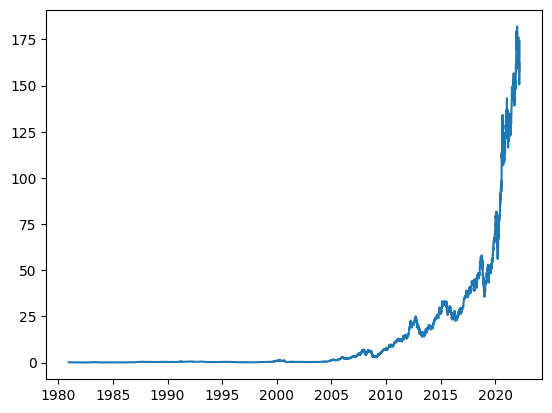

In [240]:
plt.plot(data['Date'], data['Close'])

выберем срез для обучения:

In [241]:
data_set  = data[9000:]

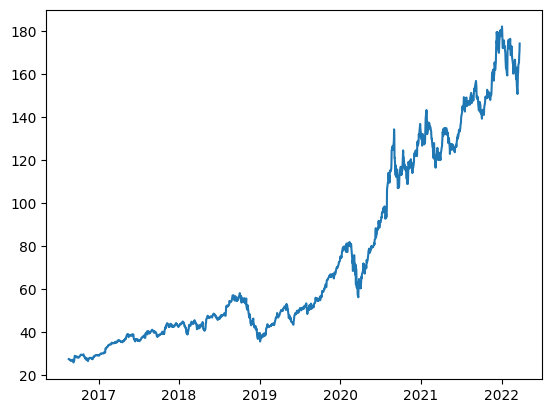

In [242]:
plt.plot(data_set['Date'], data_set['Close'])

In [243]:
import sklearn.preprocessing

class MyData:
    def __init__(self, data, test_size = 0.3 ) -> None:
        self.data = data

        scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
        self.data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))

        self.train_dataset = self.data[:int(len(self.data)*(1.-test_size))]
        self.test_dataset = self.data[int(len(self.data)*(1.-test_size)):]

    def show(self):
        plt.plot(self.train_dataset['Date'], self.train_dataset['Close'])
        plt.plot(self.test_dataset['Date'], self.test_dataset['Close'])

    def get_train(self):
        return  self.train_dataset['Close'].to_numpy()
    
    def get_test(self):
        return  self.test_dataset['Close'].to_numpy()


In [244]:
dataset = MyData(data_set, 0.2)

C:\Users\Filic\AppData\Local\Temp\ipykernel_37252\4241873540.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1,1))


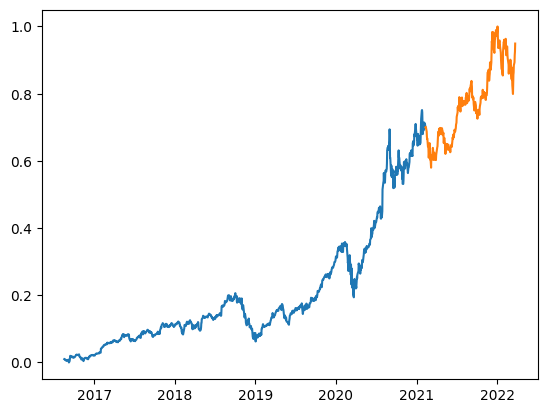

In [245]:
dataset.show()

Напишем класс датасета с созданием пакетов:

In [246]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, step = 50):
        super(MyDataset, self).__init__()
        self.data = self.get_data(data.astype(np.float32), step)

    def __getitem__(self, index):
        return self.data[0][index].reshape((-1, 1)), self.data[1][index].reshape((-1, 1))

    def __len__(self):
        return len(self.data[0])
    
    def get_data(self, data, step):
        x=[]
        y=[]

        for index in range(len(data)-step):
            x.append(data[index:index+step])
            y.append(data[index+step])

        x = np.array(x)
        x = x
        y = np.array(y)
        return (x, y)

In [247]:
step = 50

In [248]:
train_dataset = MyDataset(dataset.get_train(), step)

Напишем даталоудер

In [249]:
batch = 1

In [250]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)

Создадим модедь

In [251]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.drop = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])

        return out

model = LSTM(1, step, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

Обучение сети:

In [252]:
from tqdm import tqdm

In [253]:
def train(epoch, model, optimizer, criterion, dataloader, save = False):
    model.train()
    # loop over the dataset multiple times
    for epoch in range(epoch):
        running_loss = 0.0
        for datainp in (pdbar := tqdm(dataloader)):
            inputs, labels = datainp
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pdbar.set_description(f'epoch: {epoch}\tloss: {running_loss:.3F}')
        if save:
            torch.save(model, f'my_model_epoch_{epoch}.pth')
    print('Finished Training')
    model.eval()

Обучение

In [254]:
train_check = True

epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

In [255]:
if train_check:
    train(epoch, model, optimizer, criterion, train_dataloader)

  0%|          | 0/1077 [00:00<?, ?it/s]c:\Users\Filic\.conda\envs\pythorch\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch: 0	loss: 5.332: 100%|██████████| 1077/1077 [00:06<00:00, 178.05it/s]

Finished Training


Проверка модели:

In [261]:
def test(model, datalouder):
    out = []
    for item in (pdbar := tqdm(datalouder)):
        inputs = item[0].to(device)
        #print(inputs)

        outputs = model(inputs)
        outputs = outputs.cpu().detach().numpy()[0][0]
        out.append(outputs)

    out = np.array(out)
    dataset.show()
    plt.plot(dataset.data['Date'].to_numpy()[step:], out)
    plt.show()

        

In [262]:
test_datalset = MyDataset(dataset.data['Close'].to_numpy(), step)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

100%|██████████| 1359/1359 [00:01<00:00, 747.35it/s]


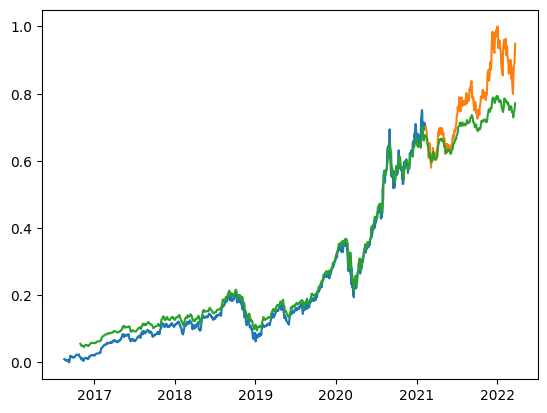

In [263]:
test(model, test_dataloader)